<a href="https://colab.research.google.com/github/SasankaMallikarachchi/BiLSTM-NER-Sinhala/blob/main/KerasNER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### import english corpus

In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Research/DL/ner_dataset.csv", encoding = "latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
n_words

35179

In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


###Sentence getter for Eglish corpus

In [ ]:
import random

getter = SentenceGetter(data)
sentences = getter.sentences

random.shuffle(sentences)
len(sentences)

47959

###Sentence getter for Sinhala corpus

In [ ]:
training_data = "//content/drive/MyDrive/Research/taggedData/200k.txt"
import io
import random

def load_data(p):
  f = io.open(p, "r")
  sentences = []
  target = []
  data = f.read().split("\n\n")
  for i in data:
    s = i.split("\n")
    sen = []
    t = []
    for j in s:
      w = j.split(" ")
      if len(w)==2:
        sen.append(w)
      else:
        print(w)
        print(s)
    sentences.append(sen)
  return sentences

sin_sentences = load_data(training_data)
print(sin_sentences[2])

random.shuffle(sin_sentences)

for a in sin_sentences:
  for j in a:
    if(j[1]=="B-PER" or j[1]=="I-PER"):
      j[1]="PER"
    if(j[1]=="B-LOC" or j[1]=="I-LOC"):
      j[1]="LOC"
    if(j[1]=="B-ORG" or j[1]=="I-ORG"):
      j[1]="ORG"

print(sin_sentences[1])

words_1 = []
tags_1 = ["O","PER","LOC","ORG"]
for n in sin_sentences:
  for k in n:
    words_1.append(k[0])
    # tags_1.append(k[1])


def get_unique(my_list):
  unique = []
  for i in my_list:
    if i not in unique:
      unique.append(i)
  return unique

words = get_unique(words_1)
tags = get_unique(tags_1)
words.append("0")
n_tags = len(tags)
n_words = len(words)
print(n_words, n_tags)

['']
['', '']
['']
['', '']
[['පාසල', 'O'], ['සම්බන්ධයෙන්', 'O'], ['පැවැත්වෙන', 'O'], ['විමර්ශනය', 'O'], ['නිසා', 'O'], ['මෙම', 'O'], ['අනුයුක්ත', 'O'], ['කිරීම', 'O'], ['සිදුකළ', 'O'], ['බව', 'O'], ['අධ්\u200dයාපන', 'B-ORG'], ['අමාත්\u200dයංශය', 'I-ORG'], ['කියයි', 'O'], ['.', 'O']]
[['මහජන', 'O'], ['සේවය', 'O'], ['පිණිස', 'O'], ['කැපවිය', 'O'], ['යුතු', 'O'], ['පොලිස්', 'O'], ['නිල', 'O'], ['ඇඳුමේ', 'O'], ['අසූචි', 'O'], ['තවරා', 'O'], ['ගැනීම', 'O'], ['නිසා', 'O'], ['අද', 'O'], ['මේ', 'O'], ['ඕඅයිසී', 'O'], ['හාදයාට', 'O'], ['විඳවන්නට', 'O'], ['සිදුව', 'O'], ['ඇති', 'O'], ['බව', 'O'], ['පෙනේ', 'O'], ['.', 'O']]
30343 4


In [ ]:
len(sin_sentences)

10005

###Plot sentence length

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


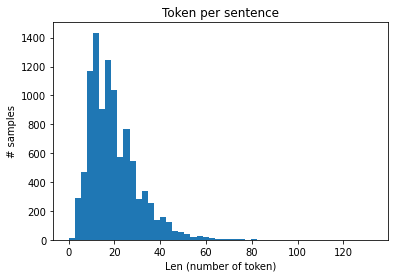

In [ ]:
 import matplotlib.pyplot as plt

# csfont = {'fontname':'Times New Roman'}
plt.rcParams["font.family"] = "Times New Roman"


plt.hist([len(s) for s in sin_sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

### Generate index

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
print(word2idx["ඔබ"])
print(tag2idx["PER"])

print(idx2word[1])
print(idx2tag[0])
print(idx2tag[1])
print(idx2tag[2])
print(idx2tag[3])

7211
1
අය
O
PER
LOC
ORG


In [ ]:
X = [[word2idx[w[0]] for w in s] for s in sin_sentences]
y = [[tag2idx[w[1]] for w in s] for s in sin_sentences]

# X = [[word2idx[w[0]] for w in s] for s in sentences]
# y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_len = 50

# value = n-words-1 which is 'ENDPAD'or index 35178
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [ ]:
import keras
import keras.utils
from tensorflow.keras import utils as np_utils
from tensorflow.keras.utils import to_categorical
# from keras_visualizer import visualizer 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
# One hot encoding
# n_tags = 17
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]

In [ ]:
y[0].shape
# y[0]

(50,)

In [ ]:
y_test[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import numpy as np

# !pip install git+https://www.github.com/keras-team/keras-contrib.git

# ! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
# from keras_contrib.layers import CRF


In [ ]:
# ! pip install keras-crf
# from keras_crf import CRFModel

In [ ]:
# ! pip install tf2crf

# # from tf2CRF import CRF
# from tensorflow.keras.models import Model
# from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
# from keras_contrib.layers import CRF

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=45, return_sequences=True, recurrent_dropout=0.3))(model)
# additionl layer
# model = LSTM(units=50, return_sequences=True,  recurrent_dropout=0.4)(model)
model = Dropout(0.4)(model)
# model = Dense(n_tags)(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

# crf = CRF(n_tags)
# out = crf(model)

model = Model(input, out)

opt = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]) 

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 50)            1517150   
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 90)            34560     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 90)            0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 50, 4)             364       
Total params: 1,552,074
Trainable params: 1,552,074
Non-trainable params: 0
_________________________________________________

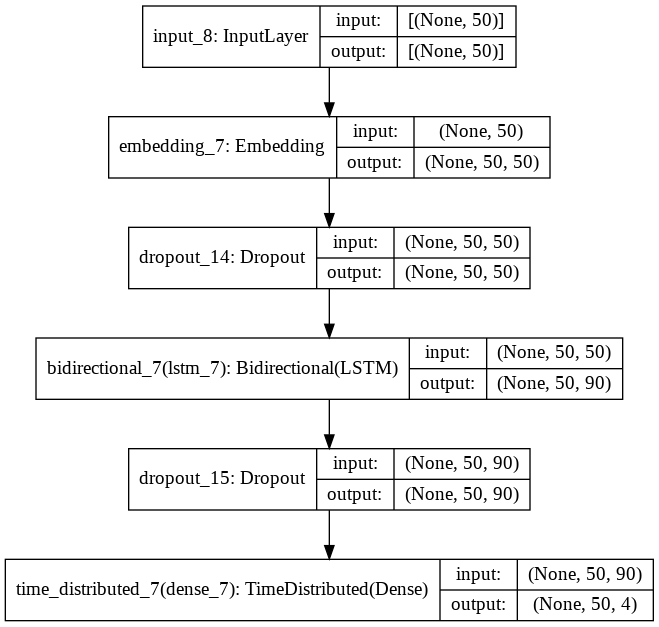

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/Research/DL/model4.png', show_shapes=True)

In [ ]:
history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    verbose=2)

Epoch 1/10
Epoch 2/10
226/226 - 25s - loss: 0.0465 - accuracy: 0.9841 - val_loss: 0.0489 - val_accuracy: 0.9845
Epoch 3/10
226/226 - 25s - loss: 0.0282 - accuracy: 0.9905 - val_loss: 0.0474 - val_accuracy: 0.9854
Epoch 4/10
226/226 - 25s - loss: 0.0219 - accuracy: 0.9926 - val_loss: 0.0509 - val_accuracy: 0.9856
Epoch 5/10
226/226 - 25s - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.0525 - val_accuracy: 0.9851
Epoch 6/10
226/226 - 25s - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0528 - val_accuracy: 0.9852
Epoch 7/10
226/226 - 25s - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.0569 - val_accuracy: 0.9853
Epoch 8/10
226/226 - 25s - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0584 - val_accuracy: 0.9851
Epoch 9/10
226/226 - 25s - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0605 - val_accuracy: 0.9850
Epoch 10/10
226/226 - 25s - loss: 0.0104 - accuracy: 0.9964 - val_loss: 0.0687 - val_accuracy: 0.9850


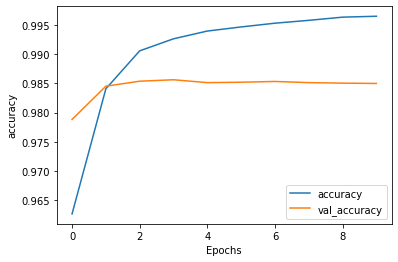

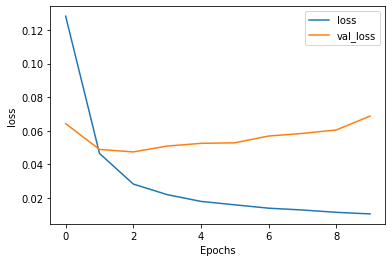

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
X_test[5]
#  වෙබ් මත ඕනෑම තැනක, ඔබ තෝරන භාෂාවෙන් ටයිප් කිරීම

array([ 2536,  3047,   292,  3048,   115,  2331,  3049,  3050,   814,
        1503,    67,    38,  1510,   858,    19, 30342, 30342, 30342,
       30342, 30342, 30342, 30342, 30342, 30342, 30342, 30342, 30342,
       30342, 30342, 30342, 30342, 30342, 30342, 30342, 30342, 30342,
       30342, 30342, 30342, 30342, 30342, 30342, 30342, 30342, 30342,
       30342, 30342, 30342, 30342, 30342], dtype=int32)

In [ ]:
i = 241
p = model.predict(np.array(X_test))
p = np.argmax(p, axis=-1)

# print("{:15} {:5}".format("Word",  "Pred"))
# for w, pred in zip(X_test[i], p[0]):
#     print("{:15}: {}".format(words[w], tags[pred]))
print(X_test[4])

[ 9790  4083   980 16536 16537   790  1882   226   998   441    19 30342
 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342
 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342
 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342 30342
 30342 30342]


In [ ]:
p.shape
print(p[15])
print(y_test[15])
# print(np.argmax(y_test[3],axis=1))
# new_y = np.argmax(y_test,axis=1)
type(p)
y_dsh = y_test.tolist()
p_dsh = p.tolist()

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
y_dsh[10][2]

0

In [ ]:
def my_replace(arr1):
  one_dlist = []
  for i in arr1:
    for j in i:
      one_dlist.append(j)

  return one_dlist

prediction = my_replace(p_dsh)
actual = my_replace(y_dsh)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import io

def evaluation(t, p):
  print(len(t),len(p))
  print("Macro")
  print(precision_recall_fscore_support(t, p, average='macro'))
  print("Micro")
  print(precision_recall_fscore_support(t, p, average='micro', labels=[1,2,3]))
  print("Label wise")
  print(precision_recall_fscore_support(t, p, average=None,  labels=[1,2,3]))
  print("Confusion Matrix")
  print(confusion_matrix(t, p))
  print("accuracy")
  print(accuracy_score(t,p))

# labels=['PER','LOC', 'ORG']

def count(lst, term):
  c = 0
  for i in lst:
    if i == term:
      c+=1
  return c

In [ ]:
print(count(actual, 1))
print(count(actual, 2))
print(count(actual, 3))

evaluation(actual, prediction)

544
722
632
50050 50050
Macro
(0.870534051815112, 0.7834046981556055, 0.8233079637438868, None)
Micro
(0.8223443223443223, 0.7096944151738672, 0.7618778280542986, None)
Label wise
(array([0.93832599, 0.78636364, 0.76717557]), array([0.78308824, 0.71883657, 0.63607595]), array([0.85370741, 0.75108538, 0.69550173]), array([544, 722, 632]))
Confusion Matrix
[[47941    19    92   100]
 [  105   426     7     6]
 [  182     5   519    16]
 [  184     4    42   402]]
accuracy
0.9847752247752247


##K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

y= np.asarray(y)

inputs = X
targets = y


In [ ]:
from sklearn.model_selection import KFold

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

y= np.asarray(y)

inputs = X
targets = y

acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2,
                    verbose=1)
  plot_graphs(history, "accuracy")
  plot_graphs(history,"loss")
  
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
226/226 [==============================] - 43s 192ms/step - loss: 0.0465 - accuracy: 0.9846 - val_loss: 0.0721 - val_accuracy: 0.9822
Epoch 2/10
226/226 [==============================] - 44s 193ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 0.0698 - val_accuracy: 0.9824
Epoch 3/10
147/226 [==================>...........] - ETA: 14s - loss: 0.0484 - accuracy: 0.9838

KeyboardInterrupt: ignored

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
plt.plot(acc_per_fold)

In [ ]:
plt.plot(loss_per_fold)

In [ ]:
! pip install keras-crf

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import numpy as np

In [ ]:
import tensorflow as tf

from keras_crf import CRFModel

# build backbone model, you can use large models like BERT


# sequence_input = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='sequence_input')
# outputs = tf.keras.layers.Embedding(100, 128)(sequence_input)
# outputs = tf.keras.layers.Dense(256)(outputs)
# base = tf.keras.Model(inputs=sequence_input, outputs=outputs)

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = tf.keras.layers.Dense(256)(outputs)
base = Model(input,model)


# build CRFModel, 5 is num of tags
model = CRFModel(base, 5)

model = CRFModel(base, n_tags)

# no need to specify a loss for CRFModel, model will compute crf loss by itself
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    metrics=['acc'])
# you can now train this model
model.fit(X_train, np.array(y_train), epochs=10, callbacks=None)

# or summary the model
model.build(tf.TensorShape([None, 256]))
model.summary()